<a href="https://colab.research.google.com/github/PierreSylvain/covid-chestxray-detector/blob/master/covid_chestxray_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Load images

In [2]:
# Load zipped  images directory and decompress into data folder
!wget https://filedn.com/lvsbt6znCCkhw76TPAmL9PL/data.zip
!unzip -q -o /content/data.zip
!ls /content/data/train 

--2020-05-30 08:46:07--  https://filedn.com/lvsbt6znCCkhw76TPAmL9PL/data.zip
Resolving filedn.com (filedn.com)... 74.120.9.25
Connecting to filedn.com (filedn.com)|74.120.9.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166593773 (159M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 158.88M  44.9MB/s    in 6.5s    

2020-05-30 08:46:14 (24.5 MB/s) - ‘data.zip’ saved [166593773/166593773]

0_normal  1_covid


# Load libraries

In [0]:
# Load libraries
import os
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#import random

# Keras
#import keras
#from keras.utils import to_categorical
#from keras.models import Sequential

#from keras.layers import Conv2D
#from keras.layers import MaxPooling2D
from keras.layers import Dense
#from keras.layers import Activation
from keras.layers import Flatten
#from keras.layers import MaxPool2D
#from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout


from keras.optimizers import SGD
#from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.inception_v3 import InceptionV3

#from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')


# Create model

In [0]:
# Create data generator
# One for train data and other for val and test
def data_generator():
  datagen = ImageDataGenerator(
    rescale= 1 / 255.0,
    rotation_range=15,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    fill_mode="nearest")  
  return  datagen

def data_generator_basic():
  datagen = ImageDataGenerator(rescale= 1 / 255.0)  
  return  datagen 

In [0]:
# VGG19 Model
def vgg_model(image_width, image_height):
  vgg_model = VGG19(include_top=False, input_shape=(image_width, image_height, 3))
  
  for layer in vgg_model.layers[:-3]:
    layer.trainable = False

  avg = AveragePooling2D(pool_size=(4, 4))(vgg_model.layers[-1].output)
  flat1 = Flatten()(avg)
  
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1) 
  dropout1 = Dropout(0.5)(class1)  
  
  output = Dense(1, activation='sigmoid')(dropout1)
  
  model = Model(inputs=vgg_model.inputs, outputs=output)
  opt = SGD(lr=0.001, momentum=0.9)  
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()
  return model

# Train model

In [35]:
# Train model
nb_epochs = 80
image_width = 320
image_height = 382
train_dir = "/content/data/train"
test_dir = "/content/data/test"

model = vgg_model(image_width,image_height)

datagen = data_generator()
datagen_basic = data_generator_basic()

# Prepare
train = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(image_width, image_height))
val = datagen_basic.flow_from_directory( test_dir,  class_mode='binary', batch_size=64, target_size=(image_width, image_height))

# Train model
history = model.fit_generator(
    train, 
    steps_per_epoch=len(train), 
    validation_data=val, 
    validation_steps=len(val), 
    epochs=nb_epochs,    
    verbose=1)

# Save model 
model.save('VGG-covid19.h5')

# Evaluate
_, acc = model.evaluate_generator(val, steps=len(val), verbose=1)
print('Model accuracy %.3f' % (acc * 100.0))


Found 216 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Epoch 1/80
4/4 [==============================] - 14s 3s/step - loss: 0.9591 - accuracy: 0.5324 - val_loss: 0.6687 - val_accuracy: 0.6909
Epoch 2/80
4/4 [==============================] - 12s 3s/step - loss: 0.7542 - accuracy: 0.5741 - val_loss: 0.6652 - val_accuracy: 0.6000
Epoch 3/80
4/4 [==============================] - 13s 3s/step - loss: 0.7504 - accuracy: 0.5324 - val_loss: 0.6115 - val_accuracy: 0.7455
Epoch 4/80
4/4 [==============================] - 13s 3s/step - loss: 0.6548 - accuracy: 0.5926 - val_loss: 0.7254 - val_accuracy: 0.4000
Epoch 5/80
4/4 [==============================] - 12s 3s/step - loss: 0.6883 - accuracy: 0.6019 - val_loss: 0.6503 - val_accuracy: 0.6000
Epoch 6/80
4/4 [==============================] - 13s 3s/step - loss: 0.6203 - accuracy: 0.6065 - val_loss: 0.5549 - val_accuracy: 0.7455
Epoch 7/80
4/4 [==============================] - 12s 3s/step - loss: 0.6105 - accuracy: 0.

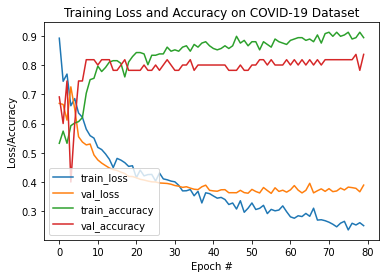

In [36]:
# Training Loss and Accuracy visualization
plt.figure()
plt.plot(np.arange(0, nb_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, nb_epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, nb_epochs), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, nb_epochs), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

# Make predictions

In [37]:
pred_dir = "/content/data"

# load model
#model = load_model('VGG-covid19.h5')

y_preds = []
ys = []

# Make prediction 
datagen = data_generator_basic()
predict_generator = datagen.flow_from_directory( pred_dir, classes=['predict'], batch_size=1, class_mode=None, shuffle=False, target_size=(image_width, image_height))
preds = model.predict_generator(predict_generator)

# Create array of values to be predicted
# The first character of the filename is the value to predict
for idx, item in enumerate(predict_generator.filenames):
  line = os.path.basename(item)
  y = re.sub(r"^(.)-.*$", r"\1", line)
  ys.append(int(y))

  y_pred = 0;
  if(preds[idx][0] > 0.7):
        y_pred = 1;
  y_preds.append(y_pred)
  #print(f"{os.path.basename(item):70} {preds[idx][0]:<20} {y_pred}")

Found 31 images belonging to 1 classes.


[[12  3]
 [ 1 15]]


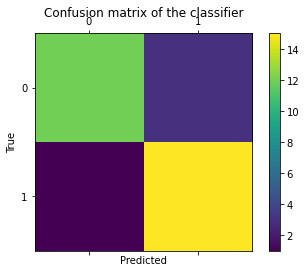

In [38]:
# Show confusion matrix
labels = [0, 1]
cm = confusion_matrix(ys, y_preds, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
print(confusion_matrix(ys, y_preds))
print(classification_report(ys, y_preds))

[[12  3]
 [ 1 15]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.83      0.94      0.88        16

    accuracy                           0.87        31
   macro avg       0.88      0.87      0.87        31
weighted avg       0.88      0.87      0.87        31

